<a href="https://colab.research.google.com/github/ngoc11224756/sentiment_analyst/blob/main/m__h_nh_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.1 which is incompatible.


In [ ]:
import transformers
print(transformers.__version__)

4.28.1


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dulieu2.csv to dulieu2.csv


In [ ]:
import pandas as pd

# Đổi tên file nếu cần
data = pd.read_csv("dulieu2.csv")  # Thay bằng đúng tên file bạn upload


In [ ]:
# Hàm phân loại xu hướng dựa trên tương tác

def classify_popularity(like_count, share_count):
    total_interactions = like_count + share_count
    if total_interactions >= 10:
        return 'Highly Popular'
    elif total_interactions >= 5:
        return 'Popular'
    else:
        return 'Less Popular'


In [ ]:
# 1. Lớp tiền xử lý dữ liệu
# ------------------------------
import re
class DataPreprocessor:
    def __init__(self, file_path, standard_columns):
        self.file_path = file_path
        self.standard_columns = standard_columns

    def load_data(self):
        """
        Đọc dữ liệu từ file CSV. KHÔNG gọi dropna() ở đây,
        để tránh mất dữ liệu ở các cột không quá quan trọng.
        """
        data = pd.read_csv(self.file_path, low_memory=False)
        if 'reviews.date' in data.columns:
            data['reviews.date'] = pd.to_datetime(data['reviews.date'], errors='coerce')
        return data

    def standardize_columns(self, data, col_mapping=None):
        """
        Chuyển đổi tên các cột theo dictionary mapping. Nếu một cột
        không có trong dữ liệu gốc thì tạo cột đó với giá trị None.
        """
        if col_mapping:
            data = data.rename(columns=col_mapping)
        for col in self.standard_columns:
            if col not in data.columns:
                data[col] = None
        return data

    def fill_missing(self, data, subset=None):
        """
        Thay vì dropna() toàn bộ:
     Chỉ drop các dòng thiếu cột 'review' (hoặc cột cần thiết).
        Mặc định: Không xóa dữ liệu.
        """
        if subset is not None:
            data = data.dropna(subset=subset)
        return data

    def clean_text(self, text):
        """
        Chuyển văn bản về chữ thường và loại bỏ ký tự đặc biệt.
        """
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return text

    def process_text(self, data, text_col):
        """
        Tạo cột 'cleaned_text' và 'text_length' nếu cột text_col tồn tại.
        """
        if text_col in data.columns:
            data['cleaned_text'] = data[text_col].apply(self.clean_text)
            data['text_length'] = data['cleaned_text'].apply(lambda x: len(x.split()))
        return data

# Pipelie xử lý dữ liệu
#------------------------------
standard_columns = ['id', 'name', 'date', 'product_category', 'review', 'cleaned_text', 'rating', 'like_count', 'share_count', 'popularity_category', 'sentiment_score','sentiment_category']
file_path = "dulieu2.csv"
preprocessor = DataPreprocessor(file_path, standard_columns)

col_mapping = {
    'id': 'id',
    'name': 'name',
    'categories': 'product_category',
    'reviews.text': 'review',
    'reviews.date': 'date',
    'reviews.username': 'user_name',
    'reviews.rating': 'rating',
    'reviews.numHelpful': 'like_count',
    'shares': 'share_count'
}

data = preprocessor.load_data()
data.columns = data.columns.str.strip()
print("Các cột của dữ liệu gốc:")
print(data.columns.tolist())

data = preprocessor.standardize_columns(data, col_mapping=col_mapping)
print("Các cột sau mapping:")
print(data.columns.tolist())
if 'review' in data.columns:
    print("Nội dung cột 'review' sau mapping:")
    print(data['review'].head())

original_count = data.shape[0]
data = data.dropna(subset=['review'])
new_count = data.shape[0]
print(f"Đã loại bỏ {original_count - new_count} dòng do thiếu dữ liệu.")

data = preprocessor.process_text(data, 'review')

data['like_count'] = data['like_count'].fillna(0)
data['share_count'] = data['share_count'].fillna(0)
data['popularity_score'] = data['like_count'] + data['share_count']
data['popularity_category'] = data.apply(lambda row: classify_popularity(row['like_count'], row['share_count']), axis=1)

data = data[standard_columns]
print("Dữ liệu sau tiền xử lý:")
print(data.head(20))
data = data[data['cleaned_text'].str.strip() != '']
print("Số bản ghi có văn bản hợp lệ:", len(data))
print("Tiền xử lý hoàn tất!")

Các cột của dữ liệu gốc:
['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username']
Các cột sau mapping:
['id', 'name', 'asins', 'brand', 'product_category', 'keys', 'manufacturer', 'date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'like_count', 'rating', 'review', 'reviews.title', 'user_name', 'cleaned_text', 'share_count', 'popularity_category', 'sentiment_score', 'sentiment_category']
Nội dung cột 'review' sau mapping:
0    Great size, easy to carry for traveling. Need ...
1    I purchased this when my last tablet died. It ...
2    Perfect for downloading and reading books !! P...
3    I was surprised when I learned of the capabili...
4    I got it for my son. Its user friendly and dur...
Name: review, dtype: object
Đã loại bỏ 1 dòng 

<ipython-input-7-7026252c53db>:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['share_count'] = data['share_count'].fillna(0)


In [ ]:
# Thêm các import cần thiết
import os
import torch
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Kiểm tra GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"💻 Device: {device}")

# Kiểm tra dữ liệu đầu vào
assert not data.empty, "Dataframe rỗng - kiểm tra đường dẫn file CSV"
required_columns = ['cleaned_text', 'sentiment_category']
assert all(col in data.columns for col in required_columns), f"Thiếu các cột: {required_columns}"

# Mã hóa nhãn
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment_category'])
num_labels = len(label_encoder.classes_)

# Chia tập train/test
train_df, val_df = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=data['label']  # Thêm stratify để cân bằng lớp
)
# Dataset class
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.texts = df['cleaned_text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float32)
        }


💻 Device: cuda


In [ ]:
# Khởi tạo model
model_name = "distilbert-base-multilingual-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier

In [ ]:
# Training arguments
os.makedirs('./my_results', exist_ok=True)

training_args = TrainingArguments(
    output_dir='./my_results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 200,
    save_steps = 200,
    learning_rate=2e-5,
    #fp16=True,  # Disable FP16 for CPU training
    fp16=torch.cuda.is_available(), # Enable FP16 only if CUDA is available
    dataloader_num_workers=0,
    logging_dir='./logs',
    load_best_model_at_end=True,
    report_to="none",
    gradient_accumulation_steps=2 if device == "cuda" else 1,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    greater_is_better=True
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=TextDataset(train_df, tokenizer, 128),
    eval_dataset=TextDataset(val_df, tokenizer, 128),
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, np.argmax(pred.predictions, axis=1))}
)


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:645: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
# Huấn luyện
try:
    trainer.train()
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("Lỗi bộ nhớ! Thử:")
        print("- Giảm batch size")
        print("- Dùng gradient accumulation")
        print("- Giảm độ dài sequence")
    raise

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


Step,Training Loss,Validation Loss,Accuracy
200,No log,0.000009,1.000000
400,No log,0.000002,1.000000
600,0.000200,0.000001,1.000000
800,0.000200,0.000001,1.000000


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', a

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# Use AutoTokenizer to automatically detect the correct tokenizer type
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Use AutoModelForSequenceClassification to automatically detect the correct model type
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
# Lưu model
model.save_pretrained('./distilbert_sentiment_model')
tokenizer.save_pretrained('./distilbert_sentiment_model')



('./distilbert_sentiment_model/tokenizer_config.json',
 './distilbert_sentiment_model/special_tokens_map.json',
 './distilbert_sentiment_model/vocab.txt',
 './distilbert_sentiment_model/added_tokens.json',
 './distilbert_sentiment_model/tokenizer.json')

In [ ]:

# Dự đoán
def predict_sentiment(text):
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=1).item()
        return predicted_class + 1  # vì nhãn là từ 0->4 đại diện cho 1->5 sao

data['predicted_sentiment'] = data['cleaned_text'].apply(predict_sentiment)

# Test prediction
sample_text = data.iloc[0]['cleaned_text']
print(f"Sample prediction: {predict_sentiment(sample_text)}")

Sample prediction: 5


In [ ]:
print("🎯 Nhãn đã học:", label_encoder.classes_)


🎯 Nhãn đã học: [None]


In [ ]:
def convert_star_to_label(star):
    if star <= 2:
        return 'negative'
    elif star == 3:
        return 'neutral'
    else:
        return 'positive'

# Áp dụng vào cột mới
data['predicted_label'] = data['predicted_sentiment'].apply(convert_star_to_label)


In [ ]:
display(data[['cleaned_text', 'predicted_sentiment', 'predicted_label']].head(20))


,cleaned_text,predicted_sentiment,predicted_label
0,great size easy to carry for traveling need to...,5,positive
1,i purchased this when my last tablet died it m...,5,positive
2,perfect for downloading and reading books per...,5,positive
3,i was surprised when i learned of the capabili...,5,positive
4,i got it for my son its user friendly and durable,5,positive
5,the visual quality on the fire 8 hd is amazing...,5,positive
6,if your looking for a affordable gift this is it,3,neutral
7,this is a great tablet for the price would rec...,5,positive
8,great product and im very satisfied with it i ...,5,positive
9,i purchased this tablet for my niece for chris...,5,positive


In [ ]:
from sklearn.metrics import accuracy_score

#2: Gán nhãn thực tế từ rating
def map_rating_to_label(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

data['true_label'] = data['rating'].apply(map_rating_to_label)

🎯 Accuracy: 89.58%

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.34      0.74      0.46       402
     neutral       0.23      0.43      0.30       660
    positive       0.98      0.92      0.95     15730

    accuracy                           0.90     16792
   macro avg       0.52      0.69      0.57     16792
weighted avg       0.94      0.90      0.91     16792



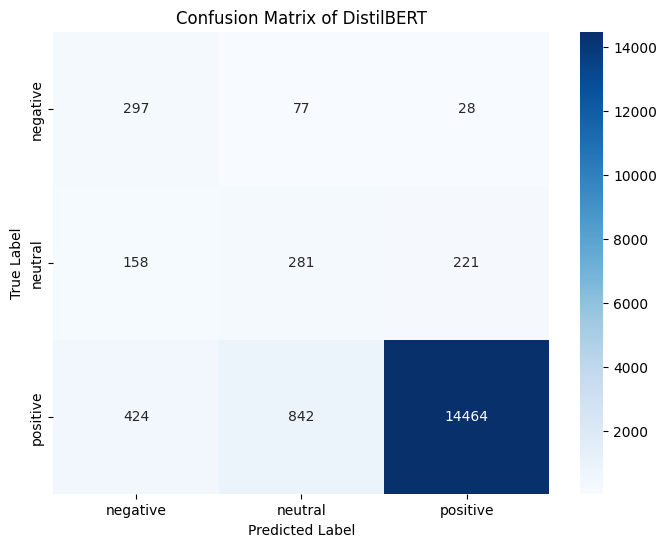

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  Nhãn thực tế và nhãn dự đoán — đảm bảo đều là string
y_true = data['true_label'].astype(str)
y_pred = data['predicted_label'].astype(str)


# Tính accuracy
acc = accuracy_score(y_true, y_pred)
print(f"🎯 Accuracy: {acc * 100:.2f}%")

# Báo cáo phân loại chi tiết
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

# Ma trận nhầm lẫn
labels = ['negative', 'neutral', 'positive']
conf_mat = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of DistilBERT")
plt.show()



In [ ]:
# Đếm số lượng bản ghi dự đoán theo từng nhãn cảm xúc
predicted_labels, counts = np.unique(y_pred, return_counts=True)
for label, count in zip(predicted_labels, counts):
    print(f"Nhóm cảm xúc {label}: {count} bản ghi")


Nhóm cảm xúc negative: 879 bản ghi
Nhóm cảm xúc neutral: 1200 bản ghi
Nhóm cảm xúc positive: 14713 bản ghi


In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
#hàm phân tích cảm xúc Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
class SentimentAnalyzer:
    def __init__(self):
        self.analyzer = SentimentIntensityAnalyzer()
    def analyze_sentiment(self, data, cleaned_col):
        print("🚀 Đang chạy analyze_sentiment...")
        """
        Áp dụng VADER để tính điểm cảm xúc (sentiment_score)
        và phân loại cảm xúc (sentiment_category).
        """
        if cleaned_col in data.columns:

            analyzer = SentimentIntensityAnalyzer()
            data['sentiment_score'] = data[cleaned_col].apply(lambda x: analyzer.polarity_scores(x)['compound'])
            print("Dữ liệu sau khi phân tích cảm xúc:")
            display(data[['cleaned_text', 'sentiment_score', 'rating']].head(10))
        return data

#Hàm gán nhãn từ VADER theo ngưỡng
    def categorize_sentiment(self,sentiment_score, threshold):
        if sentiment_score >= threshold:
            return 'positive'
        elif sentiment_score <= 0:
            return 'negative'
        else:
            return 'neutral'

In [ ]:
sentiment_analyzer = SentimentAnalyzer()
data = sentiment_analyzer.analyze_sentiment(data, 'cleaned_text')

print("Phân tích cảm xúc bằng VADER hoàn tất!")

🚀 Đang chạy analyze_sentiment...
Dữ liệu sau khi phân tích cảm xúc:


,cleaned_text,sentiment_score,rating
0,great size easy to carry for traveling need to...,0.8439,5.0
1,i purchased this when my last tablet died it m...,0.1280,4.0
2,perfect for downloading and reading books per...,0.9201,5.0
3,i was surprised when i learned of the capabili...,0.2263,4.0
4,i got it for my son its user friendly and durable,0.4939,5.0
5,the visual quality on the fire 8 hd is amazing...,0.6486,5.0
6,if your looking for a affordable gift this is it,0.4404,8.0
7,this is a great tablet for the price would rec...,0.7650,5.0
8,great product and im very satisfied with it i ...,0.8655,4.0
9,i purchased this tablet for my niece for chris...,0.6369,4.0


Phân tích cảm xúc bằng VADER hoàn tất!


In [ ]:
#Chạy vòng lặp thử nghiệm nhiều ngưỡng và tính F1-score
from sklearn.metrics import f1_score
# Khởi tạo đối tượng phân tích
analyzer = SentimentAnalyzer()

# Danh sách các ngưỡng thử nghiệm
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
f1_results = []

# Chạy thử nghiệm qua từng ngưỡng
for t in thresholds:
    data['predicted_label'] = data['sentiment_score'].apply(lambda x: analyzer.categorize_sentiment(x, t))
    f1 = f1_score(data['true_label'], data['predicted_label'], average='macro')
    f1_results.append((t, f1))
    print(f"Ngưỡng: {t:.2f} => F1-score: {f1:.4f}")
#Tìm ngưỡng tối ưu
best_threshold, best_f1 = max(f1_results, key=lambda x: x[1])
print(f"\n✅ Ngưỡng tối ưu: {best_threshold:.2f} với F1-score = {best_f1:.4f}")


Ngưỡng: 0.05 => F1-score: 0.3867
Ngưỡng: 0.10 => F1-score: 0.3920
Ngưỡng: 0.15 => F1-score: 0.3918
Ngưỡng: 0.20 => F1-score: 0.3983
Ngưỡng: 0.25 => F1-score: 0.4000
Ngưỡng: 0.30 => F1-score: 0.4040
Ngưỡng: 0.35 => F1-score: 0.4006
Ngưỡng: 0.40 => F1-score: 0.4022

✅ Ngưỡng tối ưu: 0.30 với F1-score = 0.4040


In [ ]:
# 1. Phân tích cảm xúc
data = sentiment_analyzer.analyze_sentiment(data, 'cleaned_text')
data['sentiment_category'] = data['sentiment_score'].apply(
    lambda x: sentiment_analyzer.categorize_sentiment(x, best_threshold)
)
# Hiển thị 10 dòng đầu gồm văn bản, điểm cảm xúc, nhãn thực tế và nhãn dự đoán
display(data[['cleaned_text', 'sentiment_score', 'sentiment_category', 'true_label', 'predicted_label']].head(15))

🚀 Đang chạy analyze_sentiment...
Dữ liệu sau khi phân tích cảm xúc:


,cleaned_text,sentiment_score,rating
0,great size easy to carry for traveling need to...,0.8439,5.0
1,i purchased this when my last tablet died it m...,0.1280,4.0
2,perfect for downloading and reading books per...,0.9201,5.0
3,i was surprised when i learned of the capabili...,0.2263,4.0
4,i got it for my son its user friendly and durable,0.4939,5.0
5,the visual quality on the fire 8 hd is amazing...,0.6486,5.0
6,if your looking for a affordable gift this is it,0.4404,8.0
7,this is a great tablet for the price would rec...,0.7650,5.0
8,great product and im very satisfied with it i ...,0.8655,4.0
9,i purchased this tablet for my niece for chris...,0.6369,4.0


,cleaned_text,sentiment_score,sentiment_category,true_label,predicted_label
0,great size easy to carry for traveling need to...,0.8439,positive,positive,positive
1,i purchased this when my last tablet died it m...,0.1280,neutral,positive,neutral
2,perfect for downloading and reading books per...,0.9201,positive,positive,positive
3,i was surprised when i learned of the capabili...,0.2263,neutral,positive,neutral
4,i got it for my son its user friendly and durable,0.4939,positive,positive,positive
5,the visual quality on the fire 8 hd is amazing...,0.6486,positive,positive,positive
6,if your looking for a affordable gift this is it,0.4404,positive,positive,positive
7,this is a great tablet for the price would rec...,0.7650,positive,positive,positive
8,great product and im very satisfied with it i ...,0.8655,positive,positive,positive
9,i purchased this tablet for my niece for chris...,0.6369,positive,positive,positive


🎯 Accuracy (VADER): 83.63%

📊 Classification Report (VADER):
              precision    recall  f1-score   support

    negative       0.13      0.53      0.20       402
     neutral       0.08      0.10      0.09       660
    positive       0.96      0.88      0.92     15730

    accuracy                           0.84     16792
   macro avg       0.39      0.50      0.40     16792
weighted avg       0.91      0.84      0.87     16792



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

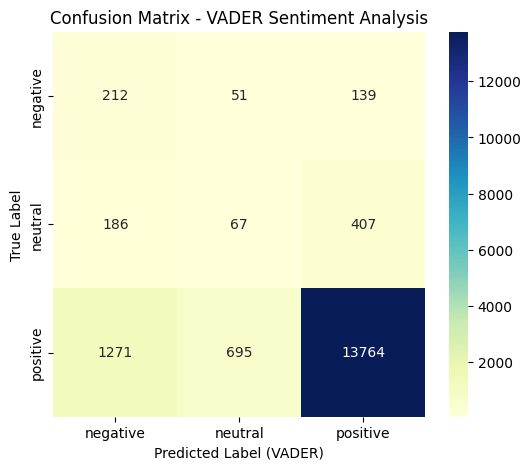

In [ ]:

# Đảm bảo các nhãn đều là string
y_true = data['true_label'].astype(str)
y_pred = data['sentiment_category'].astype(str)

# 🎯 Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 Accuracy (VADER): {accuracy * 100:.2f}%")

# 📊 Classification Report
print("\n📊 Classification Report (VADER):")
print(classification_report(y_true, y_pred))

# 🔷 Confusion Matrix
labels = ['negative', 'neutral', 'positive']
conf_mat = confusion_matrix(y_true, y_pred, labels=labels)

# Vẽ heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label (VADER)")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VADER Sentiment Analysis")
plt


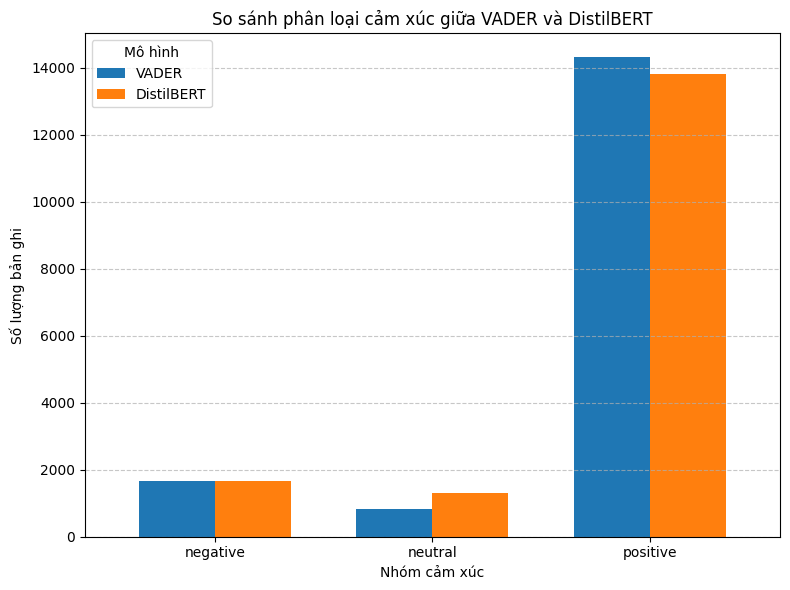

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đếm số lượng nhãn cho mỗi mô hình
vader_counts = data['sentiment_category'].value_counts().reindex(['negative', 'neutral', 'positive'], fill_value=0)
bert_counts = data['predicted_label'].value_counts().reindex(['negative', 'neutral', 'positive'], fill_value=0)

# Tạo DataFrame tổng hợp
compare_df = pd.DataFrame({
    'VADER': vader_counts,
    'DistilBERT': bert_counts
})

# Vẽ biểu đồ
compare_df.plot(kind='bar', figsize=(8, 6), width=0.7)
plt.title('So sánh phân loại cảm xúc giữa VADER và DistilBERT')
plt.xlabel('Nhóm cảm xúc')
plt.ylabel('Số lượng bản ghi')
plt.xticks(rotation=0)
plt.legend(title='Mô hình')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


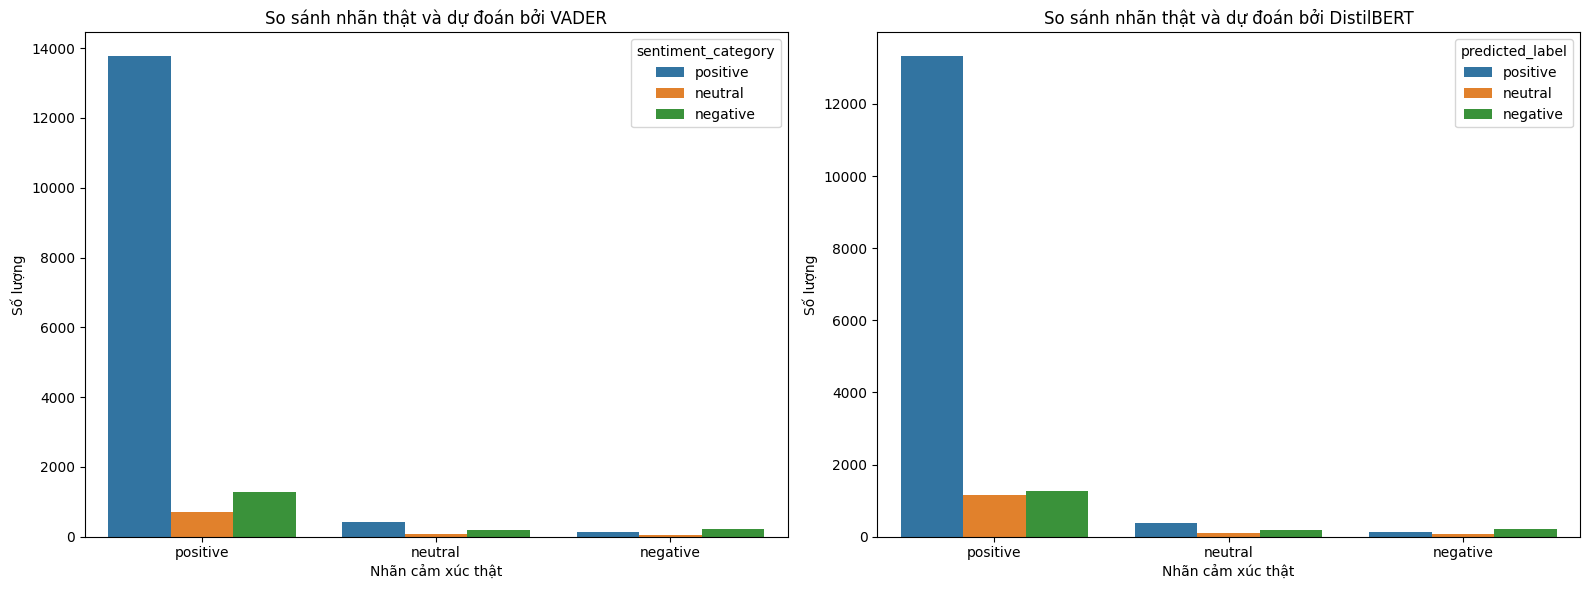

<ipython-input-28-47aec1379984>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=data, ax=axs[0], palette='cool') # Thay df bằng data
<ipython-input-28-47aec1379984>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_label', data=data, ax=axs[1], palette='magma') # Thay df bằng data


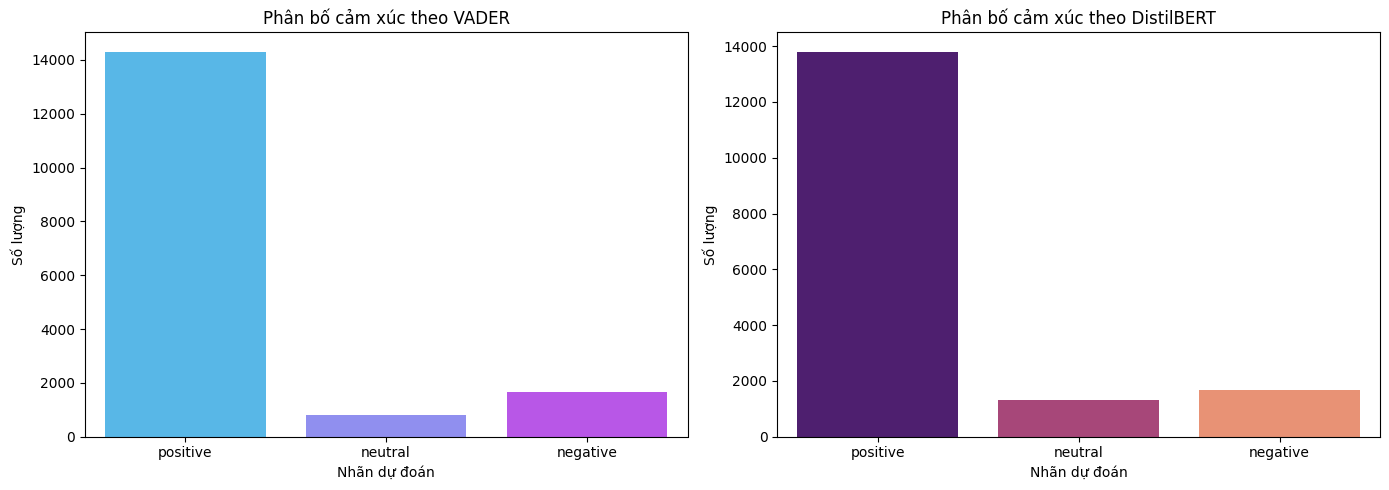

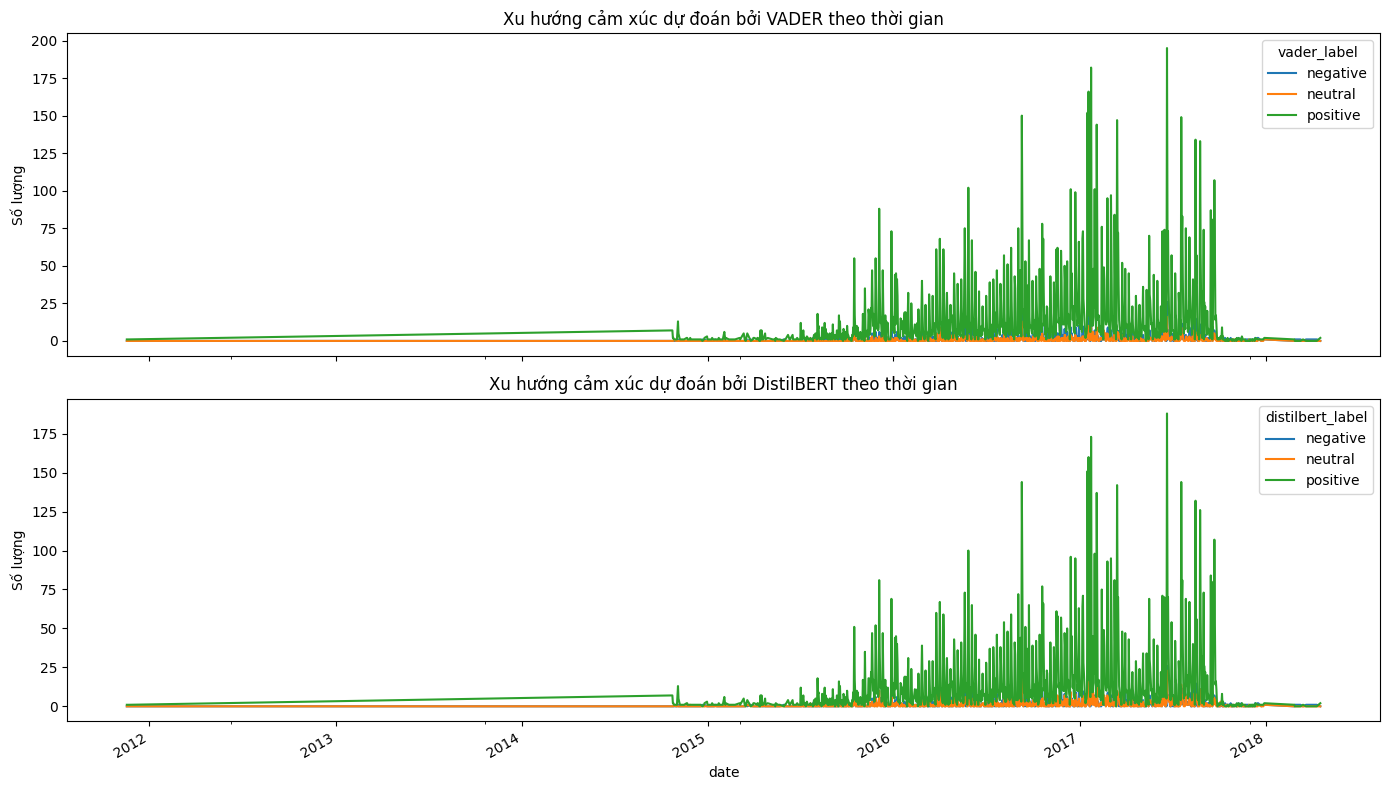

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Thay thế df bằng data (dataframe hiện tại của bạn)
# Giả sử bạn đã có dataframe data với các cột: 'true_label', 'sentiment_category', 'predicted_label', 'date' (nếu có)

# Biểu đồ cột so sánh cảm xúc dự đoán của mô hình với nhãn thật
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Thay thế 'label' bằng 'true_label', 'vader_label' bằng 'sentiment_category', 'distilbert_label' bằng 'predicted_label'
sns.countplot(x='true_label', hue='sentiment_category', data=data, ax=axs[0]) # Thay df bằng data
axs[0].set_title('So sánh nhãn thật và dự đoán bởi VADER')
axs[0].set_xlabel('Nhãn cảm xúc thật')
axs[0].set_ylabel('Số lượng')

sns.countplot(x='true_label', hue='predicted_label', data=data, ax=axs[1]) # Thay df bằng data
axs[1].set_title('So sánh nhãn thật và dự đoán bởi DistilBERT')
axs[1].set_xlabel('Nhãn cảm xúc thật')
axs[1].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()

# Biểu đồ phân bố nhãn cảm xúc giữa 2 mô hình
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Thay thế 'vader_label' bằng 'sentiment_category', 'distilbert_label' bằng 'predicted_label'
sns.countplot(x='sentiment_category', data=data, ax=axs[0], palette='cool') # Thay df bằng data
axs[0].set_title('Phân bố cảm xúc theo VADER')
axs[0].set_xlabel('Nhãn dự đoán')
axs[0].set_ylabel('Số lượng')

sns.countplot(x='predicted_label', data=data, ax=axs[1], palette='magma') # Thay df bằng data
axs[1].set_title('Phân bố cảm xúc theo DistilBERT')
axs[1].set_xlabel('Nhãn dự đoán')
axs[1].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()

# Biểu đồ đường thể hiện xu hướng cảm xúc theo thời gian (nếu có cột 'date')
if 'date' in data.columns: # Thay df bằng data
    data['date'] = pd.to_datetime(data['date']) # Thay df bằng data
    df_trend = data.copy() # Thay df bằng data
    df_trend['vader_label'] = df_trend['sentiment_category'].astype(str) # Thay 'vader_label' bằng 'sentiment_category'
    df_trend['distilbert_label'] = df_trend['predicted_label'].astype(str) # Thay 'distilbert_label' bằng 'predicted_label'

    vader_trend = df_trend.groupby(['date', 'vader_label']).size().unstack(fill_value=0)
    distilbert_trend = df_trend.groupby(['date', 'distilbert_label']).size().unstack(fill_value=0)

    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    vader_trend.plot(ax=axs[0], title='Xu hướng cảm xúc dự đoán bởi VADER theo thời gian')
    axs[0].set_ylabel('Số lượng')

    distilbert_trend.plot(ax=axs[1], title='Xu hướng cảm xúc dự đoán bởi DistilBERT theo thời gian')
    axs[1].set_ylabel('Số lượng')

    plt.tight_layout()
    plt.show()

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Widget nhập văn bản
text_input = widgets.Textarea(
    value='Tôi rất hài lòng với sản phẩm này!',
    placeholder='Nhập nội dung đánh giá...',
    description='Review:',
    layout=widgets.Layout(width='100%', height='100px')
)

# Dropdown chọn nhãn thật
true_label_dropdown = widgets.Dropdown(
    options=['positive', 'neutral', 'negative'],
    description='Nhãn thật:',
    value='positive'
)

# Nút chạy dự đoán
predict_button = widgets.Button(
    description='Phân tích cảm xúc',
    button_style='primary',
    icon='check'
)

# Output kết quả
output = widgets.Output()

# Hàm xử lý khi bấm nút
def on_predict_clicked(b):
    output.clear_output()
    text = text_input.value.strip()
    true_label = true_label_dropdown.value

    if not text:
        with output:
            print("⚠️ Vui lòng nhập nội dung để phân tích.")
        return

    with output:
        print(f"📌 Văn bản nhập vào:\n{text}\n")

        # Dự đoán với VADER
        vader_score = sentiment_analyzer.analyzer.polarity_scores(text)['compound']
        vader_label = sentiment_analyzer.categorize_sentiment(vader_score, best_threshold)
        vader_correct = "✅ ĐÚNG" if vader_label == true_label else "❌ SAI"
        print(f"🧠 VADER → Điểm: {vader_score:.3f} | Nhãn: {vader_label} ({vader_correct})")

        # Dự đoán với DistilBERT
        distilbert_star = predict_sentiment(text)
        distilbert_label = convert_star_to_label(distilbert_star)
        distilbert_correct = "✅ ĐÚNG" if distilbert_label == true_label else "❌ SAI"
        print(f"🤖 DistilBERT → Sao: {distilbert_star} | Nhãn: {distilbert_label} ({distilbert_correct})")

# Gán sự kiện cho nút
predict_button.on_click(on_predict_clicked)

# Hiển thị giao diện
display(HTML("<h3>🔍 So sánh mô hình cảm xúc: VADER vs. DistilBERT</h3>"))
display(text_input, true_label_dropdown, predict_button, output)


Textarea(value='Tôi rất hài lòng với sản phẩm này!', description='Review:', layout=Layout(height='100px', widt…

Dropdown(description='Nhãn thật:', options=('positive', 'neutral', 'negative'), value='positive')

Button(button_style='primary', description='Phân tích cảm xúc', icon='check', style=ButtonStyle())

Output()

In [ ]:
# File để ghi streamlit app trong Google Colab
with open("app.py", "w") as f:
    f.write('''
# app.py - Streamlit app cho mô hình DistilBERT vs VADER

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load model và tokenizer đã huấn luyện
@st.cache_resource
def load_model():
    model = AutoModelForSequenceClassification.from_pretrained("./distilbert_sentiment_model")
    tokenizer = AutoTokenizer.from_pretrained("./distilbert_sentiment_model")
    return model.to(device), tokenizer

# Thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"
model, tokenizer = load_model()
model.eval()

# Hàm làm sạch văn bản
def clean_text(text):
    import re
    return re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())

# Dự đoán với DistilBERT
@st.cache_data

def predict_distilbert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        return torch.argmax(probs).item() + 1

def convert_star_to_label(star):
    if star <= 2:
        return 'negative'
    elif star == 3:
        return 'neutral'
    else:
        return 'positive'

# Dự đoán với VADER
vader = SentimentIntensityAnalyzer()
def vader_sentiment(text, threshold=0.25):
    score = vader.polarity_scores(text)['compound']
    if score >= threshold:
        return 'positive'
    elif score <= 0:
        return 'negative'
    else:
        return 'neutral'

# 1. Tiêu đề app
st.set_page_config(page_title="Sentiment Analysis: DistilBERT vs VADER", layout="wide")
st.title("🔍 So sánh mô hình cảm xúc: DistilBERT vs VADER")

# 2. Tải dữ liệu
uploaded_file = st.file_uploader("📂 Tải lên file dulieu2.csv", type=["csv"])
if uploaded_file:
    data = pd.read_csv(uploaded_file)
    data['cleaned_text'] = data['review'].astype(str).apply(clean_text)
    data['true_label'] = data['rating'].apply(lambda r: convert_star_to_label(r))

    # Dự đoán cảm xúc
    st.spinner("Đang phân tích cảm xúc với 2 mô hình...")
    data['vader_label'] = data['cleaned_text'].apply(lambda x: vader_sentiment(x))
    data['bert_star'] = data['cleaned_text'].apply(predict_distilbert)
    data['bert_label'] = data['bert_star'].apply(convert_star_to_label)

    st.success("✅ Dự đoán hoàn tất!")

    # Tabs giao diện
    tab1, tab2, tab3 = st.tabs(["📊 Tổng quan", "📈 So sánh mô hình", "📝 Dự đoán từng văn bản"])

    with tab1:
        st.subheader("1. Thống kê cơ bản")
        st.write("**5 dòng đầu:**")
        st.dataframe(data.head())
        st.write("**Tổng số bản ghi:**", len(data))

        st.write("### Phân bố rating")
        fig1, ax1 = plt.subplots()
        sns.countplot(x='rating', data=data, ax=ax1)
        st.pyplot(fig1)

    with tab2:
        st.subheader("2. So sánh kết quả dự đoán")
        acc_vader = accuracy_score(data['true_label'], data['vader_label'])
        acc_bert = accuracy_score(data['true_label'], data['bert_label'])

        st.metric("🎯 Accuracy VADER", f"{acc_vader:.2%}")
        st.metric("🤖 Accuracy DistilBERT", f"{acc_bert:.2%}")

        st.write("### Ma trận nhầm lẫn")
        fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))
        sns.heatmap(confusion_matrix(data['true_label'], data['vader_label'], labels=['negative','neutral','positive']),
                    annot=True, cmap='Blues', fmt='d', ax=ax2[0])
        ax2[0].set_title("VADER")

        sns.heatmap(confusion_matrix(data['true_label'], data['bert_label'], labels=['negative','neutral','positive']),
                    annot=True, cmap='YlOrBr', fmt='d', ax=ax2[1])
        ax2[1].set_title("DistilBERT")
        st.pyplot(fig2)

    with tab3:
        st.subheader("3. Dự đoán văn bản mới")
        text_input = st.text_area("Nhập văn bản đánh giá:", "Sản phẩm này rất tốt và đáng mua!")
        true_label = st.selectbox("Nhãn thật (nếu biết):", ["positive", "neutral", "negative"], index=0)

        if st.button("Phân tích"):
            clean = clean_text(text_input)
            vader_result = vader_sentiment(clean)
            bert_star = predict_distilbert(clean)
            bert_result = convert_star_to_label(bert_star)

            st.write(f"**VADER:** {vader_result} {'✅' if vader_result == true_label else '❌'}")
            st.write(f"**DistilBERT:** {bert_result} ({bert_star} sao) {'✅' if bert_result == true_label else '❌'}")
''')
